In [ ]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

In [2]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [3]:
def myround(x, base=5):
    return base * round(x/base)

In [4]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [5]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [6]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

In [7]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [8]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.show()
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    #plt.close()

In [9]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [ ]:
all_proportions = [[0.45, 0.55], [0.4, 0.6], [0.35, 0.65], [0.3, 0.7], [0.25, 0.75], [0.2, 0.8], [0.15, 0.85], [0.1, 0.9], [0.05, 0.95]]
all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []
for proportions_list in all_proportions:
    for proportion in proportions_list:
        print(proportion)
        durations = []
        root_times = []
        relative_root_times = []

        diff = []
        moments = []

        for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
            #print(scardec_name)
            momentrate_opt, time_opt, db = get_stf(scardec_name)
            mag = get_mag(scardec_name)

            not_zero = np.where(momentrate_opt > 0)[0]

            dx = time_opt[1]-time_opt[0]

            start = min(not_zero)
            end = max(not_zero)
            points_before_zero = abs(min(time_opt)/dx)

            duration = time_opt[end] - time_opt[start]
            durations.append(duration)

            start_time = time_opt[start]
            end_time = time_opt[end]

            total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
            moments.append(total_moment)
            root, r = scipy.optimize.bisect(f3,
                                            start_time+dx,
                                            end_time,
                                            rtol = 1e-6,
                                            full_output = True,
                                            args = (total_moment,
                                                    time_opt,
                                                    momentrate_opt,
                                                    start,
                                                    points_before_zero,
                                                    proportion,))
            root_idx = np.floor(root/dx)
            root_time = root_idx*dx
            root_times.append(root_time)
            relative_root_times.append(root_time-start_time)

            if root_time-start_time > duration:
                print('root time greater than duration, proportion:', proportion)
                print(scardec_name)

        root_times = np.array(root_times)
        durations = np.array(durations)
        moments = np.log10(np.array(moments))
        relative_root_times = np.array(relative_root_times)

        rel_root_times = relative_root_times/durations

        bs = bootstrap(rel_root_times, proportion = 0.5)

        bs_means = np.mean(bs, axis = 1)

        bs_means = np.sort(bs_means)

        lower = bs_means[25]
        upper = bs_means[975]

        print(f'lower: {lower}, mean: {np.mean(rel_root_times)}, upper: {upper}')
        n, bins = np.histogram(rel_root_times, bins=np.arange(0, 1.01, 0.01))

        if proportion < 0.5:
            P = n/sum(n)
        else:
            Q = (n/sum(n))[::-1]

        plt.ylabel('Frequency')
        plt.xlabel('Proportion of duration to release proportion of moment')
        plt.xlim(0, 1)

        if proportion < 0.5:
            plt.stairs(P, bins, alpha = 0.5, color = 'midnightblue', label = f'{proportion*100:.0f}%', fill = True)
            plt.axvline(x = lower, color = 'lightskyblue')#, linestyle = ':')
            plt.axvline(x = upper, color = 'lightskyblue')#, linestyle = ':')
            plt.axvline(x = np.mean(rel_root_times), color = 'dodgerblue')
        else:
            plt.stairs(Q, bins, alpha = 0.5, color = 'darkgreen', label = f'{proportion*100:.0f}%', fill = True)
            plt.axvline(x = 1-lower, color = 'palegreen')
            plt.axvline(x = 1-upper, color = 'palegreen')
            plt.axvline(x = 1-np.mean(rel_root_times), color = 'limegreen')
    plt.ylabel('Frequency')
    plt.xlabel('Proportion of duration to release % of moment')
    plt.xlim(0, 1)
    plt.legend()
    #plt.show()
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/bootstrapping_duration_proportions/flipped_histogram_fraction_of_duration_for_{(1-proportion)*100}_{(proportion)*100}_percent_moment_bs_mean.png')
    plt.close()

0.45
lower: 0.4475249652648613, mean: 0.4527088675039734, upper: 0.45786202322213176
0.55
lower: 0.5099958707423474, mean: 0.5151793367393569, upper: 0.5203491131605997
0.4
lower: 0.41793989554900324, mean: 0.42282520260624146, upper: 0.42755743286462145
0.6
lower: 0.5447772639376071, mean: 0.5496188357050522, upper: 0.5543028766104078
0.35
lower: 0.3879714950994832, mean: 0.3930526824583438, upper: 0.3980099444467359
0.65
lower: 0.5818933864583692, mean: 0.586841020410713, upper: 0.5918922404383972
0.3
lower: 0.3580138952737636, mean: 0.36245955488043397, upper: 0.36668674180497585
0.7
lower: 0.6218672038306432, mean: 0.626528504848044, upper: 0.6311816251842466
0.25
lower: 0.32654513687150855, mean: 0.33128659775718405, upper: 0.3355466909894729
0.75
lower: 0.6656312448051703, mean: 0.6698359010176569, upper: 0.6738276788268106
0.2
lower: 0.2935623942307646, mean: 0.2976969968332346, upper: 0.3021735985822392
0.8
lower: 0.7116527866879444, mean: 0.71574124549244, upper: 0.71989258970

In [11]:
bs.shape

(1000, 2044)

In [ ]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name)

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    relative_root_times = []
    for proportion in proportions_list:
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))

        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        relative_root_times.append((root_time-start_time)/duration)
    mags = get_mag(scardec_name)
    int_mags = int(mags)

    list_for_database = [scardec_name, mags, int_mags, *relative_root_times]
    results_db.loc[len(results_db)] = list_for_database



# t_18 = rel_root_times[np.where((moments < 18))[0]]
# t_18_19 = rel_root_times[np.where((moments > 18) & (moments < 19))[0]]
# t_19_20 = rel_root_times[np.where((moments > 19) & (moments < 20))[0]]
# t_20_21 = rel_root_times[np.where((moments > 20) & (moments < 21))[0]]
# t_21_22 = rel_root_times[np.where((moments > 21) & (moments < 22))[0]]
# t_22 = rel_root_times[np.where((moments > 22))[0]]

# list_root_times = [t_18, t_18_19, t_19_20, t_20_21, t_21_22, t_22]
# moments_to_plot = [18, 19, 20, 21, 22, 23]

# upper = []
# lower = []
# for to_bs, moment in zip(list_root_times, moments_to_plot):
#     bs = bootstrap(rel_root_times, proportion = 0.5)

#     bs_means = np.mean(bs, axis = 1)

#     bs_means = np.sort(bs_means)

#     lower.append(bs_means[25])
#     upper.append(bs_means[975])

#     #print(f'lower: {lower}, mean: {np.mean(rel_root_times)}, upper: {upper}')
#     #n, bins = np.histogram(rel_root_times, bins=np.arange(0, 1.01, 0.01))

# df = pd.DataFrame({'lower': lower, 'upper': upper, 'moments': moments_to_plot, 'list_root_times': list_root_times})
# for col_name in results_db.columns[2:]:
#     ax = sns.violinplot(x = results_db[col_name], y = results_db.magnitude+(int(col_name)/100),
#         orient = 'h',
#         color = colors[col_name],
#         dodge = True)
    #ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.1))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])

# plt.xlabel(f'Proportion of duration to release % of moment')
# plt.xlim(0, 1)
# plt.legend()
# plt.show()
#     #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/bootstrapping_duration_proportions/flipped_histogram_fraction_of_duration_for_{(1-proportion)*100}_{(proportion)*100}_percent_moment_bs_mean.png')
#     #plt.close()

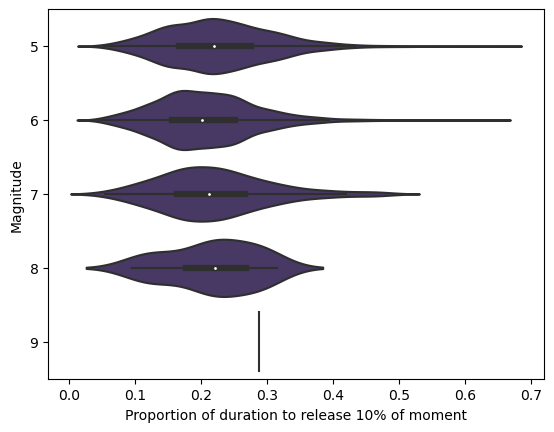

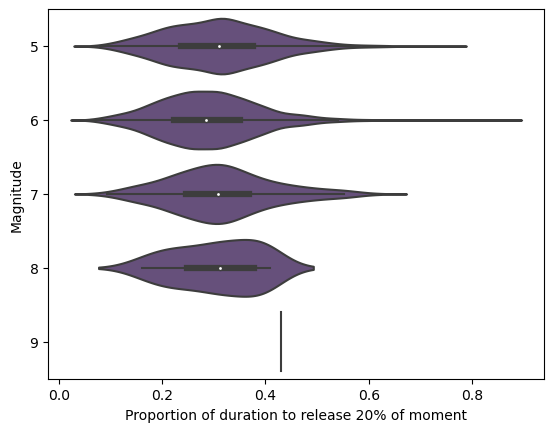

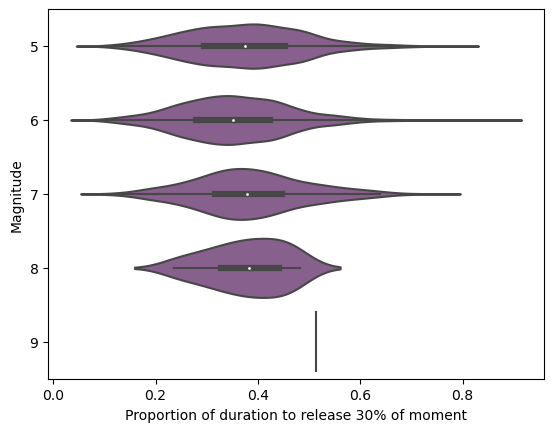

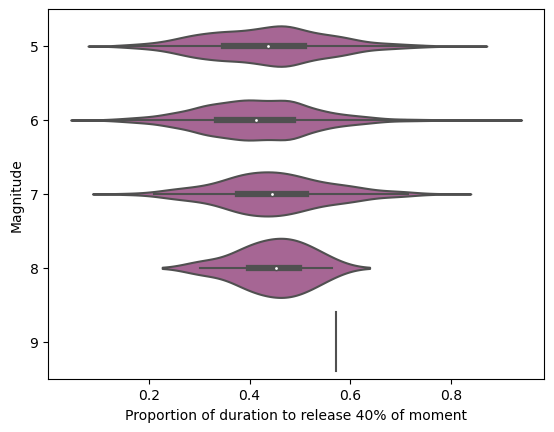

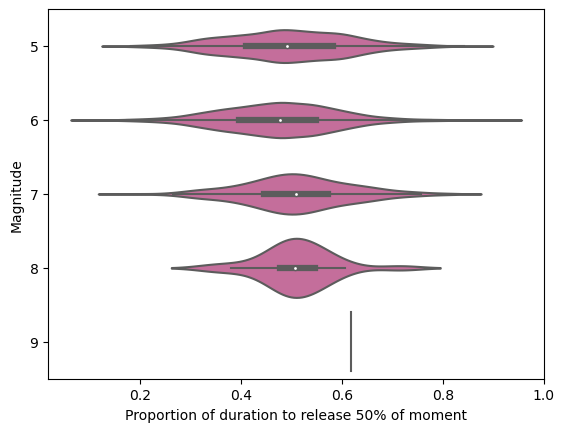

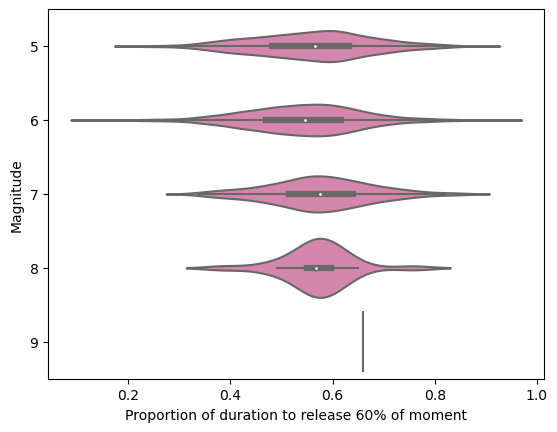

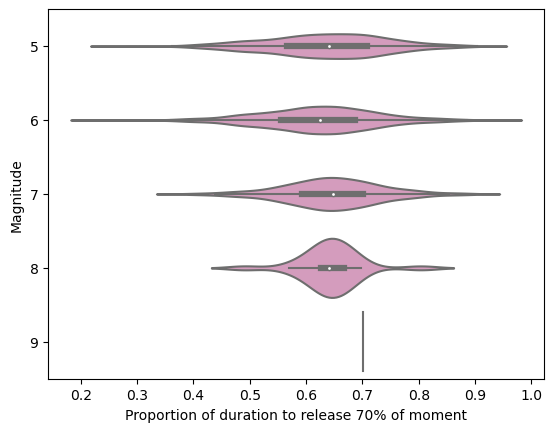

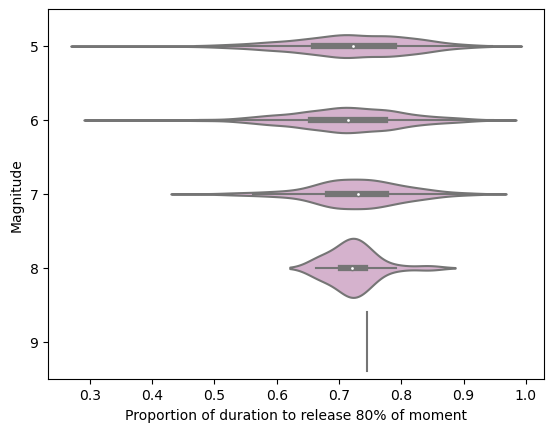

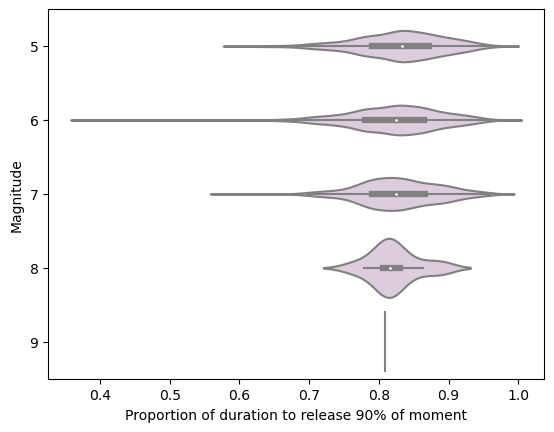

In [ ]:
for col_name in results_db.columns[3:]:
    ax = sns.violinplot(x = results_db[col_name], y = results_db.int_magnitude,
        orient = 'h',
        color = cmc.acton(int(col_name)/100),
        dodge = True,
        saturation = 1)
    plt.ylabel('Magnitude')
    plt.xlabel(f'Proportion of duration to release {col_name}% of moment')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/violin_plots/violin_plot_{col_name}percent.png')
    plt.show()

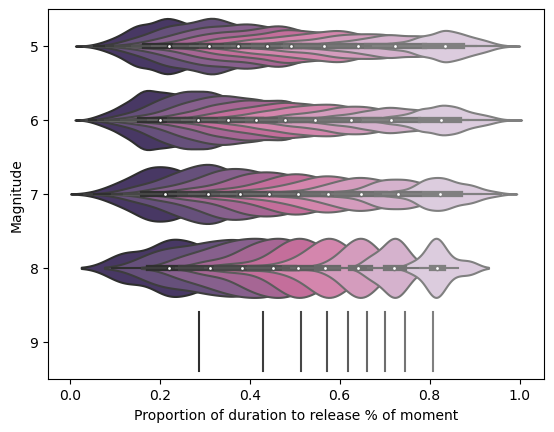

In [ ]:
for col_name in results_db.columns[3:]:
    ax = sns.violinplot(x = results_db[col_name], y = results_db.int_magnitude,
        orient = 'h',
        color = cmc.acton(int(col_name)/100),
        dodge = True,
        saturation = 1)
    plt.ylabel('Magnitude')
    plt.xlabel('Proportion of duration to release % of moment')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/violin_plots/violin_plot_stacked.png')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


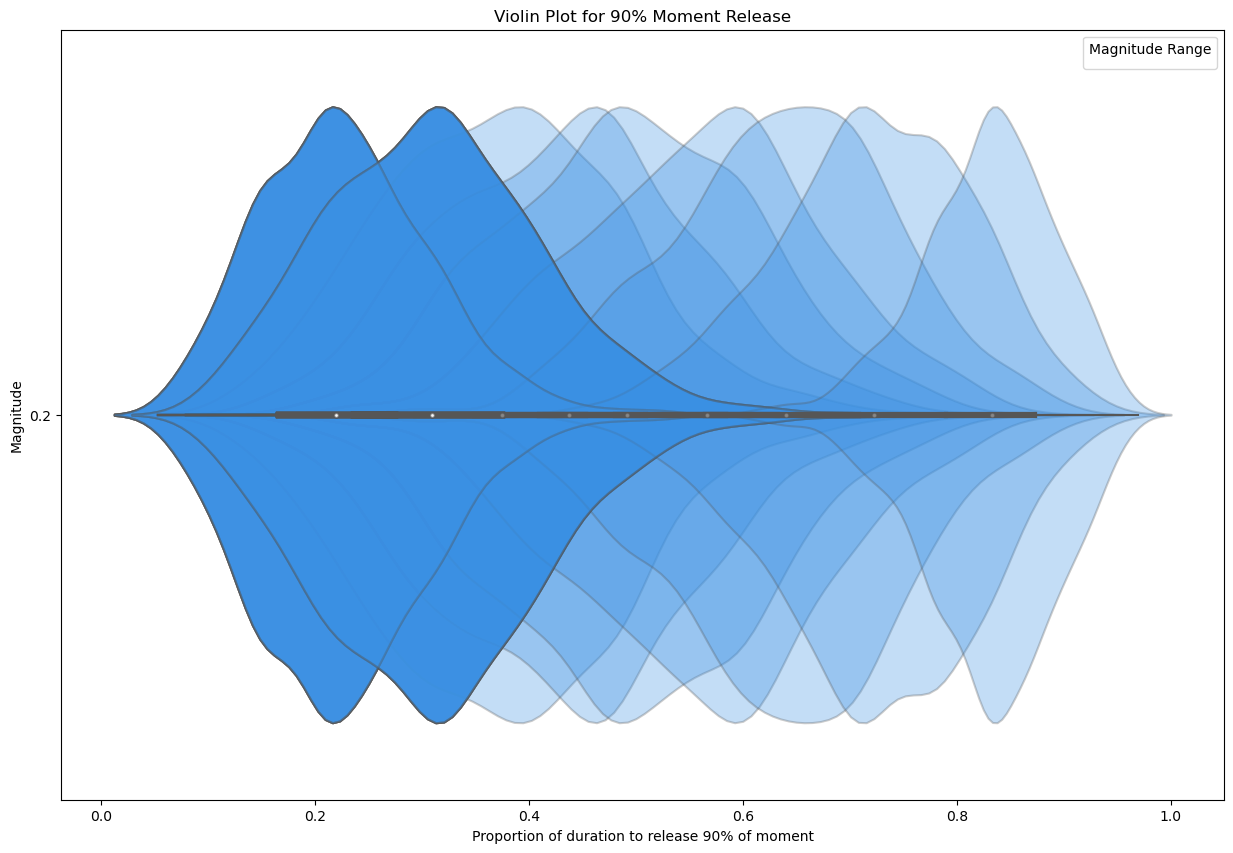

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


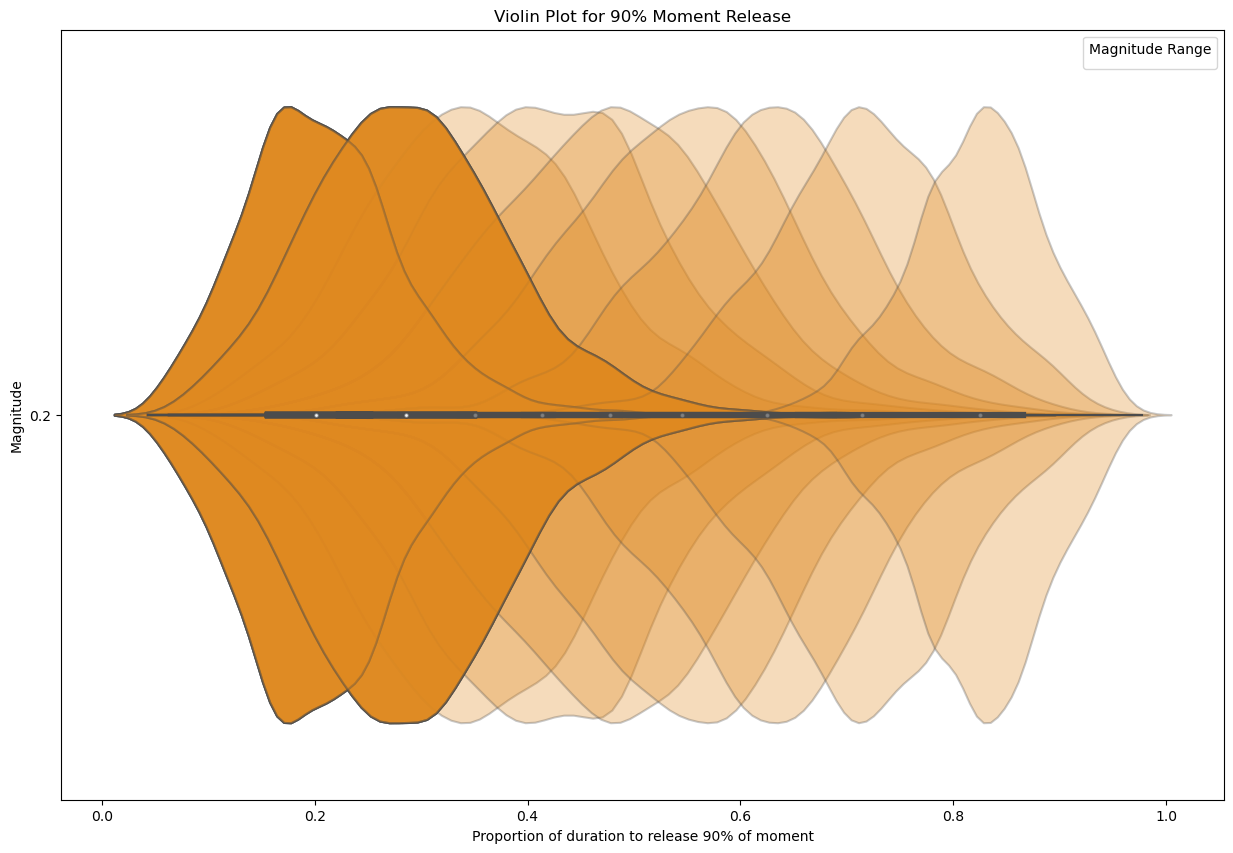

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


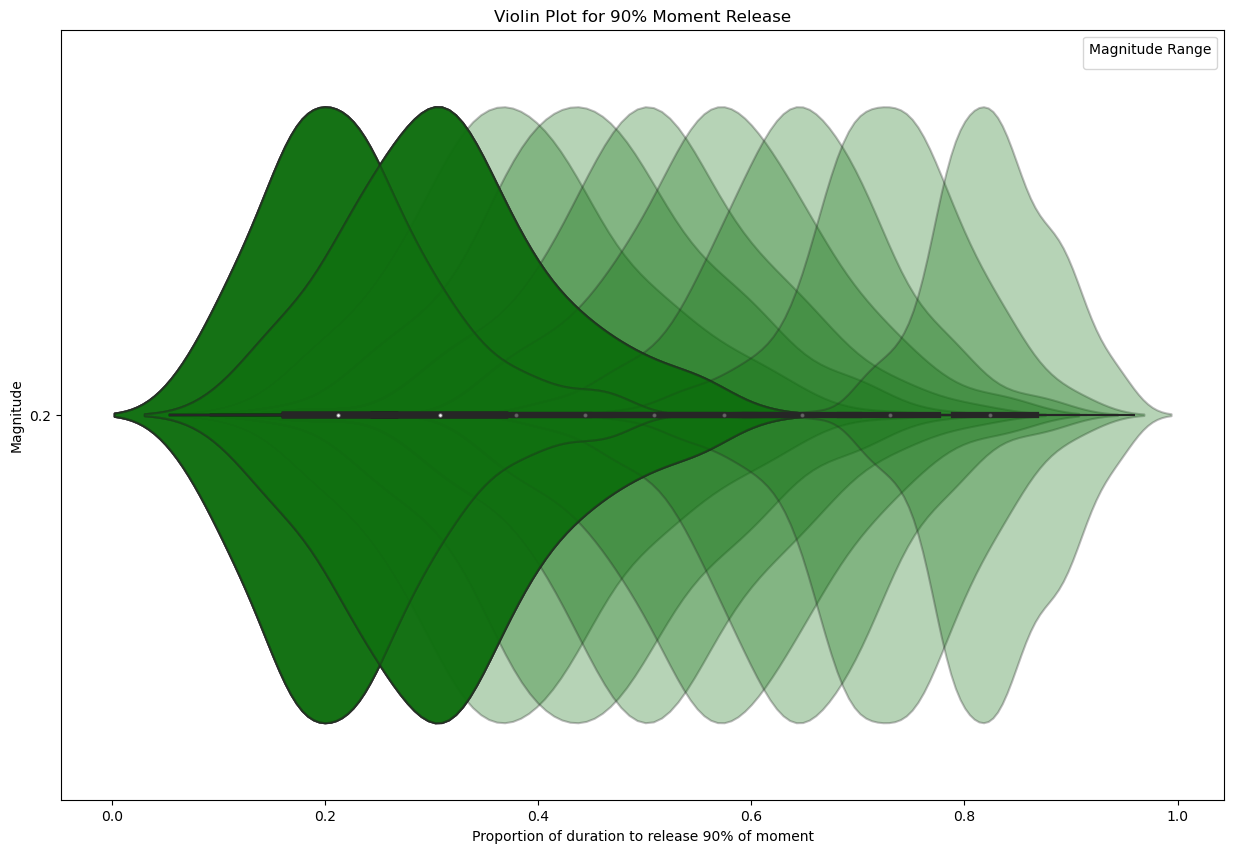

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define magnitude ranges
magnitude_ranges = [(5, 6), (6, 7), (7, 8)]

# Define colors for each magnitude range
colors = {5: 'dodgerblue', 6: 'darkorange', 7: 'green'}

# Plot violin plots for each column and magnitude range
for mag_range in magnitude_ranges:
    mag_min, mag_max = mag_range
    subset = results_db[(results_db['magnitude'] >= mag_min) & (results_db['magnitude'] < mag_max)]
    fig, ax = plt.subplots(figsize=(15, 10))
    for col_name in results_db.columns[3:]:
        # Create a new figure and axis for each col_name

        sns.violinplot(x=subset[col_name],
                    y=np.zeros(subset.shape[0]) + int(col_name),
                    orient='h',
                    color=colors[mag_min],
                    ax=ax,
                    label=f'{mag_min}-{mag_max}',
                    alpha = 0.5)
        sns.violinplot(x=subset['10'],
            y=np.zeros(subset.shape[0]) + 0.1,
            orient='h',
            color=colors[mag_min],
            ax=ax,
            label=f'{mag_min}-{mag_max}',
            alpha = 0.5,
            scale="count",
            scale_hue=False,)
        sns.violinplot(x=subset['20'],
            y=np.zeros(subset.shape[0]) + 0.2,
            orient='h',
            color=colors[mag_min],
            ax=ax,
            label=f'{mag_min}-{mag_max}',
            alpha = 0.5,
            scale="count",
            scale_hue=False,)
    plt.setp(ax.collections, alpha=.3)

    plt.ylabel('Magnitude')
    plt.xlabel(f'Proportion of duration to release {col_name}% of moment')
    plt.legend(title='Magnitude Range')
    plt.title(f'Violin Plot for {col_name}% Moment Release')
    plt.show()
    plt.close()

In [12]:
subset

,scardec_name,magnitude,int_magnitude,10,20,30,40,50,60,70,80,90
7,FCTs_20120320_180247_NEAR_COAST_OF_GUERRERO__M...,7.374,7,0.236994,0.323699,0.387283,0.439306,0.497110,0.554913,0.612717,0.676301,0.768786
11,FCTs_20040715_042714_FIJI_ISLANDS_REGION,7.045,7,0.267442,0.325581,0.360465,0.418605,0.465116,0.523256,0.604651,0.709302,0.790698
17,FCTs_19940713_023556_VANUATU_ISLANDS,7.054,7,0.201835,0.302752,0.380734,0.431193,0.495413,0.545872,0.596330,0.669725,0.761468
34,FCTs_19990119_033533_NEW_IRELAND_REGION__P.N.G,7.017,7,0.253049,0.335366,0.399390,0.457317,0.515244,0.573171,0.628049,0.689024,0.792683
40,FCTs_20061226_122621_TAIWAN_REGION,7.113,7,0.100213,0.153518,0.221748,0.283582,0.321962,0.360341,0.420043,0.533049,0.886994
...,...,...,...,...,...,...,...,...,...,...,...,...
4044,FCTs_20080320_223257_SOUTHERN_XINJIANG__CHINA,7.052,7,0.282787,0.409836,0.500000,0.569672,0.651639,0.750000,0.807377,0.852459,0.897541
4055,FCTs_20070801_170851_VANUATU_ISLANDS,7.205,7,0.382353,0.483193,0.563025,0.617647,0.663866,0.710084,0.743697,0.789916,0.844538
4065,FCTs_20040725_143519_SOUTHERN_SUMATRA__INDONESIA,7.268,7,0.192857,0.557143,0.728571,0.771429,0.800000,0.821429,0.850000,0.871429,0.921429
4075,FCTs_19950816_102728_SOLOMON_ISLANDS,7.717,7,0.159574,0.361702,0.515957,0.569149,0.620567,0.702128,0.794326,0.856383,0.911348
